In [1]:
# ============================================================
# 0. Setup (run on Kaggle with GPU)
# ============================================================

import os
import glob
import random
import math
from collections import defaultdict

import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset

import torchvision.transforms as T
import torchvision.models as models

from tqdm import tqdm

# ------------------------------------------------------------
# Reproducibility
# ------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [2]:
!pip install kagglehub
import kagglehub
DATA_DIR = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

In [3]:
# ============================================================
# 1. Load HAM10000 dataset & build DataFrame
#    (same dataset as your resnet50-skin-cancer-classification notebook)
# ============================================================

# read all image paths
images_path = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob.glob(os.path.join(DATA_DIR, "*", "*.jpg"))
}

print("Number of images found:", len(images_path))

# metadata
skin_df = pd.read_csv(os.path.join(DATA_DIR, "HAM10000_metadata.csv"))

# lesion type mapping (same as your notebook)
lesion_type_dict = {
    "nv": "Melanocytic Nevi",
    "mel": "Melanoma",
    "bkl": "Benign keratosis-like lesions ",
    "bcc": "Basal cell carcinoma",
    "akiec": "Actinic keratoses",
    "vasc": "Vascular lesions",
    "df": "Dermatofibroma",
}

# add columns
skin_df["path"] = skin_df["image_id"].map(images_path.get)
skin_df["cell_type"] = skin_df["dx"].map(lesion_type_dict.get)
skin_df["cell_type_idx"] = pd.Categorical(skin_df["cell_type"]).codes

print(skin_df.head())
print("Classes:", skin_df["cell_type"].unique())
print("Number of classes:", skin_df["cell_type_idx"].nunique())


Number of images found: 10015
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                                path  \
0  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
1  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
2  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
3  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   
4  /kaggle/input/skin-cancer-mnist-ham10000/ham10...   

                        cell_type  cell_type_idx  
0  Benign keratosis-like lesions               2  
1  Benign keratosis-like lesions               2  
2  Benign keratosis-like lesions               2  
3  Benig

In [4]:
# ============================================================
# 2. Construct Few-Shot Training Set (50/class) 
#    and Uniform Test Set (100/class)
#    Diffusion model will be trained on EXACTLY the same 350 images.
# ============================================================

# Number of samples to pick per class
NUM_TRAIN_PER_CLASS = 50      # baseline classifier training samples per class
NUM_TEST_PER_CLASS  = 50     # uniform test samples per class

# Group the dataframe by class
grouped = skin_df.groupby("cell_type_idx")

train_indices = []
test_indices  = []

for cls, group in grouped:
    cls_indices = group.index.tolist()
    
    # Select train samples
    train_sel = cls_indices[:NUM_TRAIN_PER_CLASS]
    
    # Select test samples (uniform per class)
    test_sel  = cls_indices[NUM_TRAIN_PER_CLASS : NUM_TRAIN_PER_CLASS + NUM_TEST_PER_CLASS]
    
    train_indices.extend(train_sel)
    test_indices.extend(test_sel)

# Build the few-shot train and uniform test DataFrames
train_few_df = skin_df.loc[train_indices].reset_index(drop=True)
test_df      = skin_df.loc[test_indices].reset_index(drop=True)

print("Few-shot training size:", len(train_few_df))
print("Test size:", len(test_df))

print("Training distribution:\n", train_few_df['cell_type_idx'].value_counts())
print("Test distribution:\n", test_df['cell_type_idx'].value_counts())

# This is IMPORTANT:
# Diffusion model must train on EXACTLY these same 350 samples.
diffusion_df = train_few_df.copy()

Few-shot training size: 350
Test size: 350
Training distribution:
 cell_type_idx
0    50
1    50
2    50
3    50
4    50
5    50
6    50
Name: count, dtype: int64
Test distribution:
 cell_type_idx
0    50
1    50
2    50
3    50
4    50
5    50
6    50
Name: count, dtype: int64


In [5]:
# ============================================================
# 3. PyTorch Datasets & Dataloaders
#    - diffusion: images normalized to [-1, 1] at 64x64
#    - classifier: images normalized with ImageNet stats at 64x64
# ============================================================

IMAGE_SIZE = 64  # smaller for diffusion

# transforms for diffusion model ([-1, 1] range)
diffusion_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])   # -> [-1, 1]
])

# transforms for classifier
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

clf_train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

clf_test_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        label = int(row["cell_type_idx"])
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label


# diffusion dataset (few-shot real images)
diffusion_dataset = SkinDataset(diffusion_df, transform=diffusion_transform)
diffusion_loader = DataLoader(
    diffusion_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

# classifier datasets using real images
real_train_dataset = SkinDataset(train_few_df, transform=clf_train_transform)
real_test_dataset = SkinDataset(test_df, transform=clf_test_transform)

real_train_loader = DataLoader(real_train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
real_test_loader  = DataLoader(real_test_dataset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("Diffusion dataset size:", len(diffusion_dataset))
print("Real train dataset size:", len(real_train_dataset))
print("Real test dataset size:", len(real_test_dataset))


Diffusion dataset size: 350
Real train dataset size: 350
Real test dataset size: 350


Class order: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions ', 'Dermatofibroma', 'Melanocytic Nevi', 'Melanoma', 'Vascular lesions']


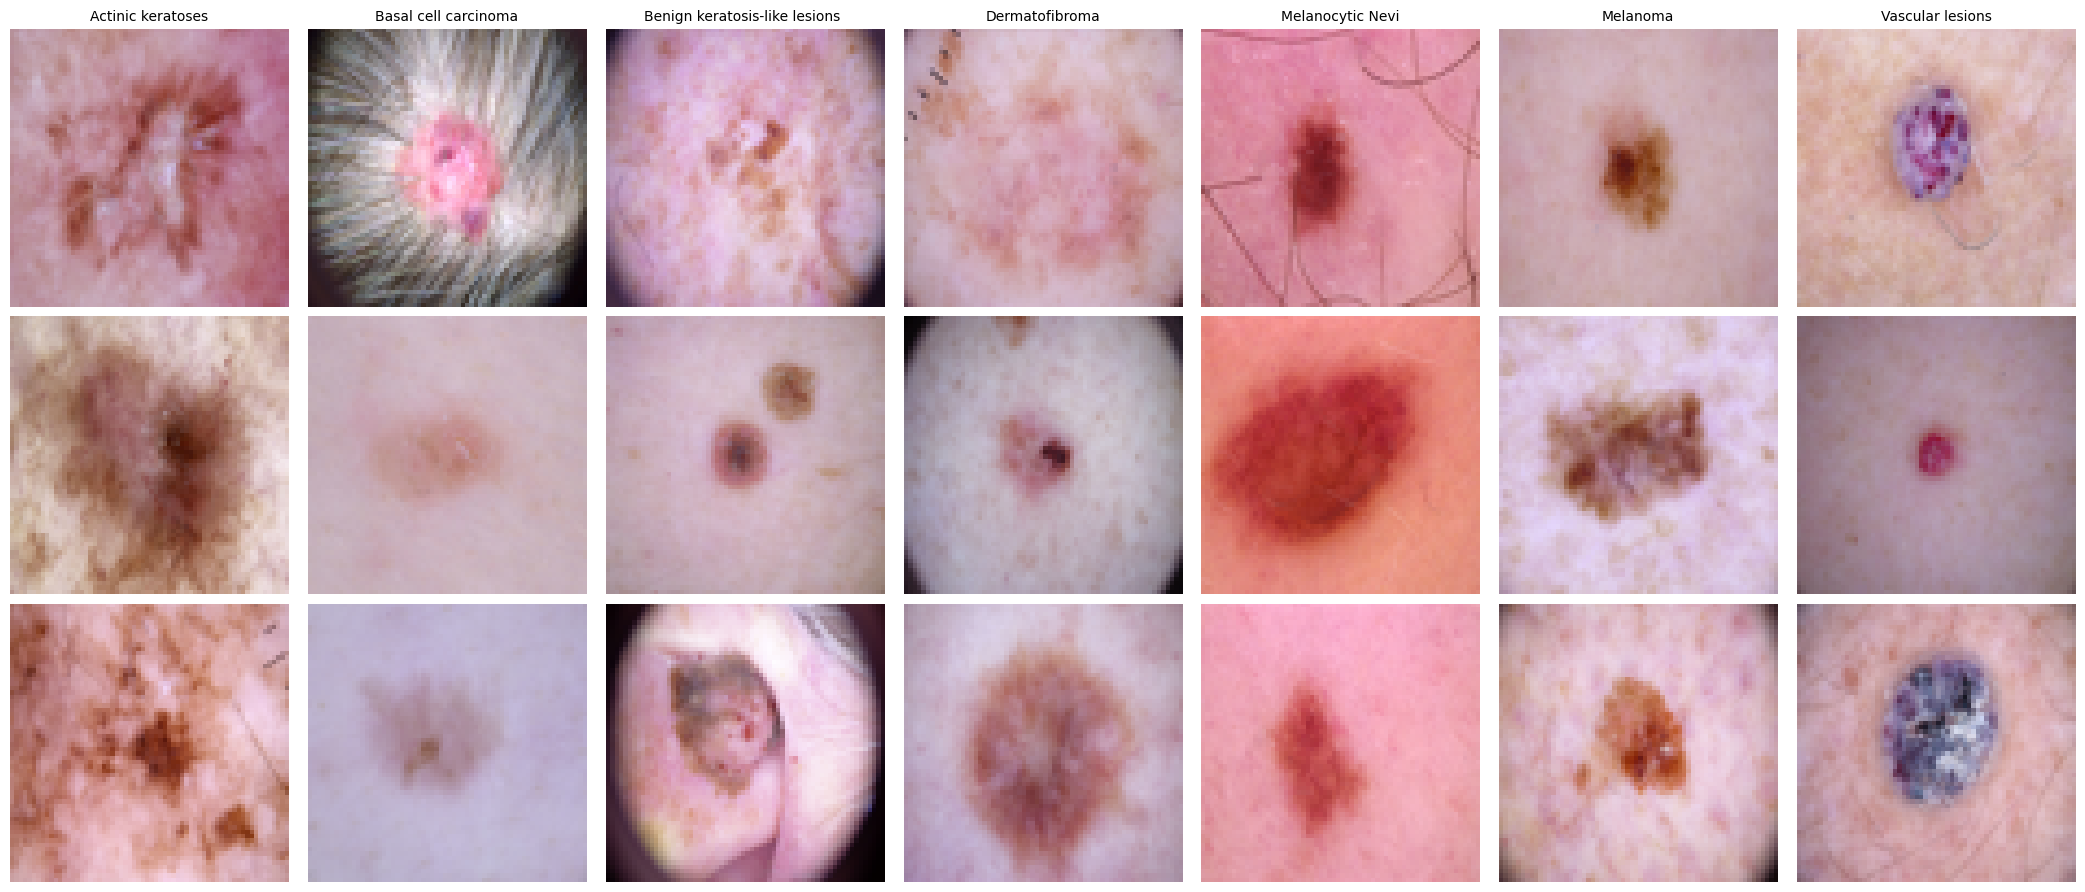

In [16]:
# ============================================================
# VISUALIZE ORIGINAL (REAL) IMAGES PER CLASS
# same exact format as diffusion samples
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# class names from skin_df
class_names = list(pd.Categorical(skin_df["cell_type"]).categories)
print("Class order:", class_names)

def load_real_tensor(img_path, image_size=64):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((image_size, image_size))
    img = torch.tensor(np.array(img)).float() / 255.0     # [0,1]
    img = img.permute(2, 0, 1)                            # (3,H,W)
    return img

def show_real_per_class(df, n_per_class=3):
    num_classes = len(class_names)
    fig, axes = plt.subplots(n_per_class, num_classes, figsize=(3*num_classes, 3*n_per_class))

    if n_per_class == 1:
        axes = np.expand_dims(axes, axis=0)

    for cls in range(num_classes):
        cls_df = df[df.cell_type_idx == cls]
        idxs = cls_df.index.tolist()

        # pick random samples
        np.random.shuffle(idxs)
        take = min(n_per_class, len(idxs))
        chosen = idxs[:take]

        for row, idx in enumerate(chosen):
            ax = axes[row, cls]

            img_path = df.loc[idx, "path"]
            img = load_real_tensor(img_path)
            img_np = img.permute(1, 2, 0).numpy()

            ax.imshow(img_np)
            ax.axis("off")
            if row == 0:
                ax.set_title(class_names[cls], fontsize=10)

        # hide empty
        for row in range(take, n_per_class):
            axes[row, cls].axis("off")

    plt.tight_layout()
    plt.show()

# Show real few-shot images (50/class)
show_real_per_class(train_few_df, n_per_class=3)


In [6]:
# ============================================================
# 4. Conditional Diffusion Model (DDPM + small U-Net)
# ============================================================

def sinusoidal_time_embedding(timesteps, dim):
    """
    timesteps: (B,)
    returns: (B, dim)
    """
    device = timesteps.device
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_emb_dim = time_emb_dim

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.SiLU()
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)

        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        if in_ch != out_ch:
            self.res_conv = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.res_conv = nn.Identity()

    def forward(self, x, t_emb):
        """
        x: (B, C, H, W)
        t_emb: (B, time_emb_dim)
        """
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)

        # add time embedding
        time_out = self.time_mlp(t_emb)
        h = h + time_out.unsqueeze(-1).unsqueeze(-1)

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)

        return h + self.res_conv(x)


class UNetConditional(nn.Module):
    def __init__(self, num_classes, time_dim=128, base_ch=64):
        super().__init__()
        self.time_dim = time_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.label_emb = nn.Embedding(num_classes, time_dim)

        self.conv_in = nn.Conv2d(3, base_ch, 3, padding=1)

        self.down1 = ResidualBlock(base_ch, base_ch * 2, time_dim)
        self.down2 = ResidualBlock(base_ch * 2, base_ch * 4, time_dim)

        self.pool = nn.MaxPool2d(2)

        self.bot1 = ResidualBlock(base_ch * 4, base_ch * 4, time_dim)
        self.bot2 = ResidualBlock(base_ch * 4, base_ch * 4, time_dim)

        self.up1 = ResidualBlock(base_ch * 4 + base_ch * 4, base_ch * 2, time_dim)
        self.up2 = ResidualBlock(base_ch * 2 + base_ch * 2, base_ch, time_dim)

        self.conv_out = nn.Conv2d(base_ch, 3, 1)

    def forward(self, x, t, y):
        # t: (B,) timesteps; y: (B,) labels
        t_emb = sinusoidal_time_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)
        y_emb = self.label_emb(y)
        t_emb = t_emb + y_emb

        x = self.conv_in(x)

        # Down
        d1 = self.down1(x, t_emb)   # (B, 2C, 64,64)
        p1 = self.pool(d1)          # (B, 2C, 32,32)

        d2 = self.down2(p1, t_emb)  # (B, 4C, 32,32)
        p2 = self.pool(d2)          # (B, 4C, 16,16)

        # Bottleneck
        b = self.bot1(p2, t_emb)
        b = self.bot2(b, t_emb)

        # Up
        u1 = F.interpolate(b, scale_factor=2, mode="bilinear", align_corners=False)  # (B,4C,32,32)
        u1 = torch.cat([u1, d2], dim=1)  # (B,8C,32,32)
        u1 = self.up1(u1, t_emb)         # (B,2C,32,32)

        u2 = F.interpolate(u1, scale_factor=2, mode="bilinear", align_corners=False)  # (B,2C,64,64)
        u2 = torch.cat([u2, d1], dim=1)  # (B,4C,64,64)
        u2 = self.up2(u2, t_emb)         # (B,C,64,64)

        out = self.conv_out(u2)          # predict noise (epsilon)
        return out


class DDPM(nn.Module):
    def __init__(self, model, num_timesteps=1000, device="cuda"):
        super().__init__()
        self.model = model.to(device)
        self.device = device
        self.num_timesteps = num_timesteps

        betas = torch.linspace(1e-4, 0.02, num_timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]], dim=0)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)

        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod))
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / alphas))

        # posterior variance
        self.register_buffer(
            "posterior_variance",
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod),
        )

    def extract(self, a, t, x_shape):
        """
        a: (T,)
        t: (B,)
        returns: (B, 1, 1, 1) broadcastable
        """
        b = t.shape[0]
        # a is a buffer already on self.device, t is on self.device too
        out = a[t].to(self.device)  # shape: (B,)
        return out.view(b, *([1] * (len(x_shape) - 1)))


    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_ac = self.extract(self.sqrt_alphas_cumprod, t, x0.shape)
        sqrt_om = self.extract(self.sqrt_one_minus_alphas_cumprod, t, x0.shape)
        return sqrt_ac * x0 + sqrt_om * noise

    def p_losses(self, x0, labels, t):
        noise = torch.randn_like(x0)
        x_noisy = self.q_sample(x0, t, noise)
        noise_pred = self.model(x_noisy, t, labels)
        return F.mse_loss(noise_pred, noise)

    @torch.no_grad()
    def p_sample(self, x, labels, t):
        betas_t = self.extract(self.betas, t, x.shape)
        sqrt_one_minus_ac_t = self.extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alpha_t = self.extract(self.sqrt_recip_alphas, t, x.shape)

        eps_theta = self.model(x, t, labels)
        model_mean = sqrt_recip_alpha_t * (x - betas_t * eps_theta / sqrt_one_minus_ac_t)
        var = self.extract(self.posterior_variance, t, x.shape)

        # if t == 0 -> no noise
        if t[0].item() == 0:
            return model_mean
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(var) * noise

    @torch.no_grad()
    def sample(self, labels, image_size=64):
        """
        labels: (B,) tensor of class indices
        returns: (B, 3, H, W) in [-1, 1]
        """
        b = labels.shape[0]
        x = torch.randn(b, 3, image_size, image_size, device=self.device)

        for i in tqdm(reversed(range(self.num_timesteps)), desc="Sampling", total=self.num_timesteps):
            t = torch.full((b,), i, device=self.device, dtype=torch.long)
            x = self.p_sample(x, labels, t)
        return x


In [7]:
# ============================================================
# 5. Train the Diffusion Model on 3000 Real Images
# ============================================================

NUM_DIFFUSION_EPOCHS = 10     # adjust down if too slow
LR_DIFFUSION = 2e-4
num_classes = skin_df["cell_type_idx"].nunique()

unet = UNetConditional(num_classes=num_classes, time_dim=128, base_ch=64)
ddpm = DDPM(unet, num_timesteps=500, device=DEVICE).to(DEVICE)

optimizer_diff = torch.optim.Adam(ddpm.parameters(), lr=LR_DIFFUSION)

ddpm.train()

for epoch in range(1, NUM_DIFFUSION_EPOCHS + 1):
    epoch_loss = 0.0
    num_batches = 0

    for x, y in tqdm(diffusion_loader, desc=f"Diffusion Epoch {epoch}", leave=False):
        x = x.to(DEVICE)     # [-1, 1]
        y = y.to(DEVICE)

        t = torch.randint(0, ddpm.num_timesteps, (x.size(0),), device=DEVICE).long()

        loss = ddpm.p_losses(x, y, t)

        optimizer_diff.zero_grad()
        loss.backward()
        optimizer_diff.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches
    print(f"[Diffusion] Epoch {epoch}/{NUM_DIFFUSION_EPOCHS} - loss: {avg_loss:.4f}")


[Diffusion] Epoch 1/10 - loss: 1.2104


[Diffusion] Epoch 2/10 - loss: 0.7356


[Diffusion] Epoch 3/10 - loss: 0.4779


[Diffusion] Epoch 4/10 - loss: 0.2407


[Diffusion] Epoch 5/10 - loss: 0.1511


[Diffusion] Epoch 6/10 - loss: 0.1187


[Diffusion] Epoch 7/10 - loss: 0.0892


[Diffusion] Epoch 8/10 - loss: 0.0857


[Diffusion] Epoch 9/10 - loss: 0.0870


[Diffusion] Epoch 10/10 - loss: 0.0725


In [8]:
import torch
torch.cuda.empty_cache()


# ============================================================
# 6. Generate 3000 Synthetic Images with Class Labels
#    - We will generate them with a roughly balanced class distribution.
# ============================================================

NUM_SYNTH = 1200

# decide how many per class (roughly balanced)
counts_per_class = [NUM_SYNTH // num_classes] * num_classes
for i in range(NUM_SYNTH % num_classes):
    counts_per_class[i] += 1

labels_list = []
for cls, count in enumerate(counts_per_class):
    labels_list.extend([cls] * count)

# keep labels on CPU; we will move them to GPU per batch
synth_labels_cpu = torch.tensor(labels_list, dtype=torch.long)
print("Synthetic label distribution:", torch.bincount(synth_labels_cpu).numpy())


@torch.no_grad()
def generate_synthetic_images_in_chunks(ddpm, labels_cpu, batch_size=64, image_size=IMAGE_SIZE):
    ddpm.eval()
    all_imgs = []

    for i in range(0, len(labels_cpu), batch_size):
        batch_labels = labels_cpu[i:i + batch_size].to(DEVICE)
        print(f"Sampling batch {i}–{i + len(batch_labels) - 1} / {len(labels_cpu)-1}")
        batch_imgs = ddpm.sample(labels=batch_labels, image_size=image_size)  # [-1, 1]
        all_imgs.append(batch_imgs.cpu())
        torch.cuda.empty_cache()  # free memory between batches

    return torch.cat(all_imgs, dim=0)


# actually generate
synth_images = generate_synthetic_images_in_chunks(ddpm, synth_labels_cpu, batch_size=32)  # you can try 64 if it fits

# Convert from [-1,1] to [0,1] for classifier
synth_images = (synth_images + 1.0) / 2.0
synth_images = torch.clamp(synth_images, 0.0, 1.0)

print("Generated synthetic images shape:", synth_images.shape)

synth_labels = synth_labels_cpu  # keep naming consistent with the rest of the notebook
synth_images_cpu = synth_images  # already on CPU

print("Synthetic labels shape:", synth_labels.shape)
print("Synthetic images shape:", synth_images_cpu.shape)

Synthetic label distribution: [172 172 172 171 171 171 171]
Sampling batch 0–31 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.56it/s]


Sampling batch 32–63 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.63it/s]


Sampling batch 64–95 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.66it/s]


Sampling batch 96–127 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.63it/s]


Sampling batch 128–159 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.63it/s]


Sampling batch 160–191 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.68it/s]


Sampling batch 192–223 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.67it/s]


Sampling batch 224–255 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.66it/s]


Sampling batch 256–287 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.67it/s]


Sampling batch 288–319 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.65it/s]


Sampling batch 320–351 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.68it/s]


Sampling batch 352–383 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.67it/s]


Sampling batch 384–415 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.66it/s]


Sampling batch 416–447 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.65it/s]


Sampling batch 448–479 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.67it/s]


Sampling batch 480–511 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.68it/s]


Sampling batch 512–543 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.66it/s]


Sampling batch 544–575 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.65it/s]


Sampling batch 576–607 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.67it/s]


Sampling batch 608–639 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.69it/s]


Sampling batch 640–671 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.59it/s]


Sampling batch 672–703 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.52it/s]


Sampling batch 704–735 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.54it/s]


Sampling batch 736–767 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.63it/s]


Sampling batch 768–799 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.60it/s]


Sampling batch 800–831 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.60it/s]


Sampling batch 832–863 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.62it/s]


Sampling batch 864–895 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.62it/s]


Sampling batch 896–927 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.51it/s]


Sampling batch 928–959 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.51it/s]


Sampling batch 960–991 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.48it/s]


Sampling batch 992–1023 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.47it/s]


Sampling batch 1024–1055 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.50it/s]


Sampling batch 1056–1087 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.50it/s]


Sampling batch 1088–1119 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.46it/s]


Sampling batch 1120–1151 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.44it/s]


Sampling batch 1152–1183 / 1199


Sampling: 100%|██████████| 500/500 [00:17<00:00, 28.45it/s]


Sampling batch 1184–1199 / 1199


Sampling: 100%|██████████| 500/500 [00:09<00:00, 54.35it/s]


Generated synthetic images shape: torch.Size([1200, 3, 64, 64])
Synthetic labels shape: torch.Size([1200])
Synthetic images shape: torch.Size([1200, 3, 64, 64])


In [14]:
# ============================================================
# 7. Build Synthetic Dataset for Classifier
# ============================================================

# For synthetic images we already have tensors in [0,1].
# We create a transform that just normalizes like ImageNet.
synth_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    # (You can add small RandomRotation if you want)
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class SyntheticTensorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: tensor (N, 3, H, W) in [0,1]
        labels: tensor (N,)
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform is not None:
            img = self.transform(img)
        label = int(self.labels[idx].item())
        return img, label

synthetic_dataset = SyntheticTensorDataset(synth_images_cpu, synth_labels_cpu, transform=synth_transform)
synthetic_loader = DataLoader(synthetic_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

print("Synthetic dataset size:", len(synthetic_dataset))


Synthetic dataset size: 1200


Class order: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions ', 'Dermatofibroma', 'Melanocytic Nevi', 'Melanoma', 'Vascular lesions']


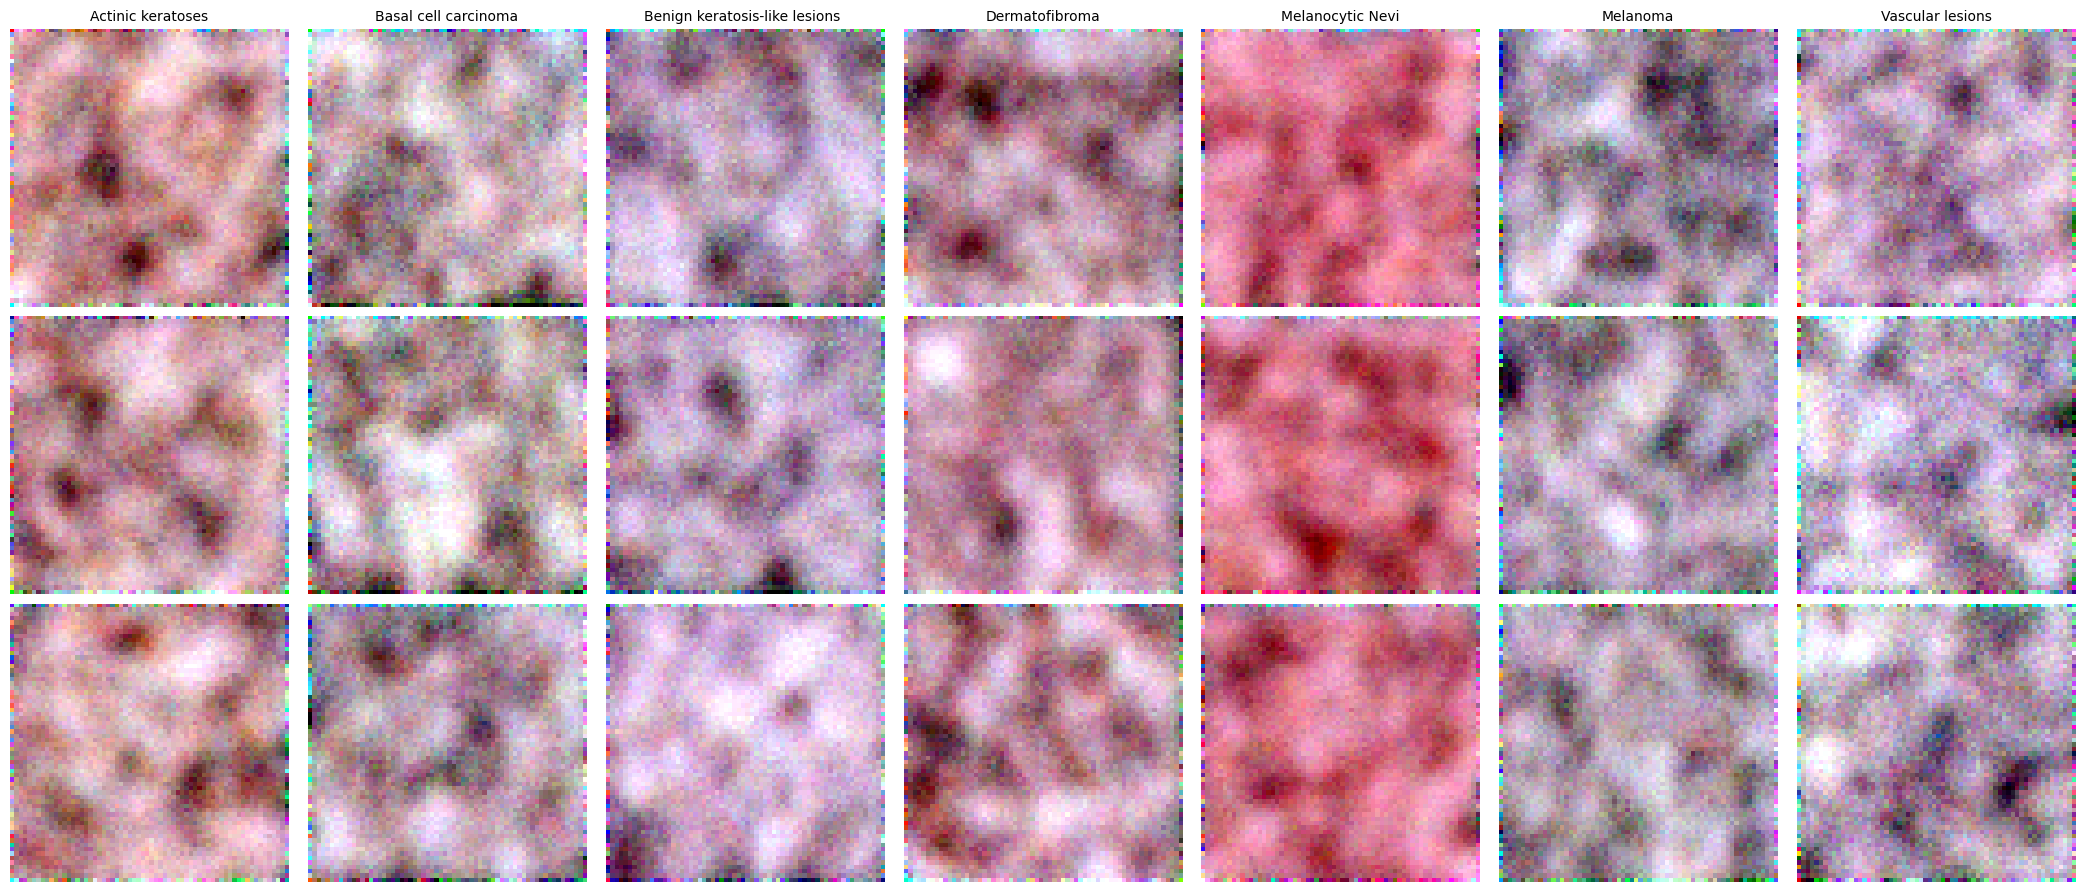

In [10]:
# ============================================================
# Visualize synthetic images from the diffusion model
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import torch

# If not already defined, get class names in the same order as cell_type_idx
class_names = list(pd.Categorical(skin_df["cell_type"]).categories)
print("Class order:", class_names)

def show_synth_per_class(images, labels, class_names, n_per_class=4):
    """
    images: tensor (N, 3, H, W) in [0,1] on CPU (synth_images_cpu)
    labels: tensor (N,) with class indices (synth_labels_cpu)
    """
    num_classes = len(class_names)
    # create a grid: rows = n_per_class, cols = num_classes
    fig, axes = plt.subplots(n_per_class, num_classes, figsize=(3*num_classes, 3*n_per_class))
    
    # When n_per_class==1, axes shape is (num_classes,), so normalize access
    if n_per_class == 1:
        axes = np.expand_dims(axes, axis=0)

    for cls in range(num_classes):
        idxs = (labels == cls).nonzero(as_tuple=True)[0]
        if len(idxs) == 0:
            continue
        # randomly pick up to n_per_class examples for this class
        perm = torch.randperm(len(idxs))
        take = min(n_per_class, len(idxs))
        chosen = idxs[perm[:take]]

        for row, idx in enumerate(chosen):
            ax = axes[row, cls]
            img = images[idx]          # (3, H, W), in [0,1]
            img_np = img.permute(1, 2, 0).numpy()
            img_np = np.clip(img_np, 0.0, 1.0)

            ax.imshow(img_np)
            ax.axis("off")
            if row == 0:
                ax.set_title(class_names[cls], fontsize=10)

        # If there are fewer than n_per_class samples for a class, hide empty cells
        for row in range(take, n_per_class):
            axes[row, cls].axis("off")

    plt.tight_layout()
    plt.show()

# Call this after you've created synth_images_cpu and synth_labels_cpu
show_synth_per_class(synth_images_cpu, synth_labels_cpu, class_names, n_per_class=3)


In [11]:
# ============================================================
# 8. Classifier: ResNet18 + Training Utilities
# ============================================================

def get_resnet18(num_classes):
    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(DEVICE)


def train_classifier(model, train_loader, test_loader, num_epochs=10, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, num_epochs + 1):
        # ---- train ----
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for x, y in tqdm(train_loader, desc=f"Classifier Epoch {epoch}", leave=False):
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            _, preds = torch.max(logits, 1)
            correct_train += (preds == y).sum().item()
            total_train += x.size(0)

        train_loss /= total_train
        train_acc = correct_train / total_train

        # ---- test ----
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0

        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                logits = model(x)
                loss = criterion(logits, y)

                test_loss += loss.item() * x.size(0)
                _, preds = torch.max(logits, 1)
                correct_test += (preds == y).sum().item()
                total_test += x.size(0)

        test_loss /= total_test
        test_acc = correct_test / total_test

        print(
            f"[Epoch {epoch}/{num_epochs}] "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
            f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}"
        )

    return train_acc, test_acc


In [15]:
# ============================================================
# 9. Three Experiments:
#    A) Only 3000 real images
#    B) Only 3000 synthetic images
#    C) Real 3000 + Synthetic 3000 (6000 total)
#    Test set is always the same (real_test_loader)
# ============================================================

NUM_CLS_EPOCHS = 5  # can reduce for speed

results = {}

# -------------------------------
# A) Train on REAL ONLY
# -------------------------------
print("\n===== Experiment A: Train on REAL (350 images) only =====")
model_real = get_resnet18(num_classes)
train_acc_real, test_acc_real = train_classifier(
    model_real,
    real_train_loader,
    real_test_loader,
    num_epochs=NUM_CLS_EPOCHS,
    lr=1e-4,
)
results["real_only"] = (train_acc_real, test_acc_real)

# -------------------------------
# B) Train on SYNTHETIC ONLY
# -------------------------------
print("\n===== Experiment B: Train on SYNTHETIC (1200 images) only =====")
model_synth = get_resnet18(num_classes)
train_acc_synth, test_acc_synth = train_classifier(
    model_synth,
    synthetic_loader,
    real_test_loader,
    num_epochs=NUM_CLS_EPOCHS,
    lr=1e-4,
)
results["synthetic_only"] = (train_acc_synth, test_acc_synth)

# -------------------------------
# C) Train on REAL + SYNTHETIC
# -------------------------------
print("\n===== Experiment C: Train on REAL + SYNTHETIC (1550 images) =====")

from torch.utils.data import ConcatDataset, DataLoader, WeightedRandomSampler
import numpy as np

combined_dataset = ConcatDataset([real_train_dataset, synthetic_dataset])

len_real = len(real_train_dataset)
len_synth = len(synthetic_dataset)
N = len_real + len_synth

# Give higher weight to real samples, lower to synthetic
w_real = 1.0
w_synth = 0.3   # try 0.3 or 0.2; tune this

weights = np.ones(N, dtype=np.float32)
weights[:len_real] = w_real
weights[len_real:] = w_synth

sampler = WeightedRandomSampler(weights, num_samples=N, replacement=True)

combined_loader = DataLoader(
    combined_dataset,
    batch_size=64,
    sampler=sampler,
    num_workers=2,
    pin_memory=True,
)


model_combined = get_resnet18(num_classes)
train_acc_combined, test_acc_combined = train_classifier(
    model_combined,
    combined_loader,
    real_test_loader,
    num_epochs=NUM_CLS_EPOCHS,
    lr=1e-4,
)
results["real_plus_synth"] = (train_acc_combined, test_acc_combined)

print("\n===== Final Summary (train_acc, test_acc) =====")
for k, v in results.items():
    print(k, ":", v)



===== Experiment A: Train on REAL (350 images) only =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1/5] train_loss=2.1566, train_acc=0.2200, test_loss=1.7983, test_acc=0.3314


[Epoch 2/5] train_loss=1.2321, train_acc=0.5629, test_loss=1.5174, test_acc=0.4171


[Epoch 3/5] train_loss=0.8873, train_acc=0.7314, test_loss=1.3312, test_acc=0.5486


[Epoch 4/5] train_loss=0.6055, train_acc=0.8400, test_loss=1.2271, test_acc=0.5914


[Epoch 5/5] train_loss=0.4331, train_acc=0.9057, test_loss=1.1797, test_acc=0.6057

===== Experiment B: Train on SYNTHETIC (1200 images) only =====


[Epoch 1/5] train_loss=1.3321, train_acc=0.4958, test_loss=2.1155, test_acc=0.1257


[Epoch 2/5] train_loss=0.4125, train_acc=0.8858, test_loss=2.2439, test_acc=0.1000


[Epoch 3/5] train_loss=0.1952, train_acc=0.9433, test_loss=2.4060, test_acc=0.1229


[Epoch 4/5] train_loss=0.1238, train_acc=0.9617, test_loss=2.4995, test_acc=0.1171


[Epoch 5/5] train_loss=0.0741, train_acc=0.9792, test_loss=2.5966, test_acc=0.1000

===== Experiment C: Train on REAL + SYNTHETIC (1550 images) =====


[Epoch 1/5] train_loss=1.4326, train_acc=0.4877, test_loss=1.3016, test_acc=0.5514


[Epoch 2/5] train_loss=0.6022, train_acc=0.8213, test_loss=1.1466, test_acc=0.6114


[Epoch 3/5] train_loss=0.3333, train_acc=0.9084, test_loss=1.1228, test_acc=0.6286


[Epoch 4/5] train_loss=0.2134, train_acc=0.9465, test_loss=1.1498, test_acc=0.6543


[Epoch 5/5] train_loss=0.1219, train_acc=0.9742, test_loss=1.1364, test_acc=0.6714

===== Final Summary (train_acc, test_acc) =====
real_only : (0.9057142857142857, 0.6057142857142858)
synthetic_only : (0.9791666666666666, 0.1)
real_plus_synth : (0.9741935483870968, 0.6714285714285714)


Per-class F1 (baseline): [0.74468085 0.41558442 0.48214286 0.47619048 0.81300813 0.53913043
 0.73684211]
Per-class F1 (augmented): [0.72727273 0.37333333 0.48148148 0.5060241  0.8        0.65306122
 0.77358491]


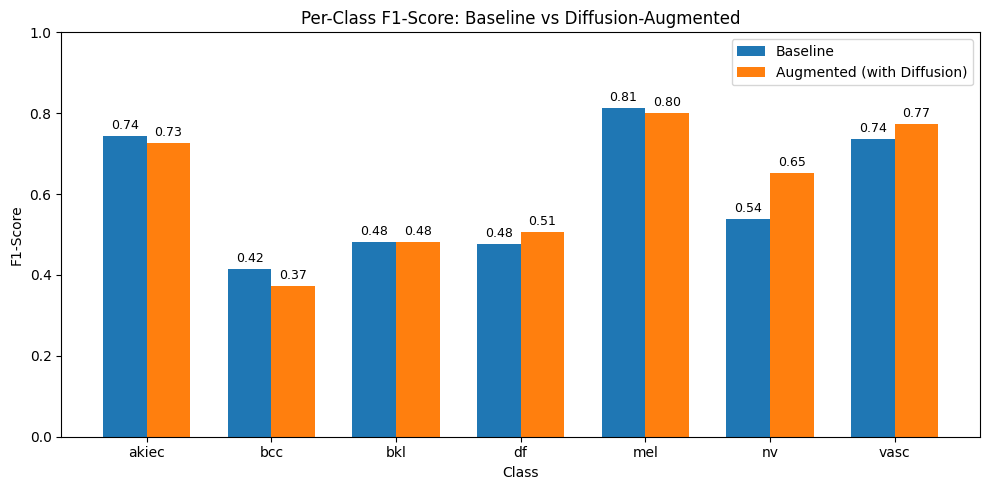

In [13]:
# ============================================================
# Per-class F1 chart: Baseline (real_only) vs Augmented (Diffusion)
# ============================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 1) Helper to get predictions & true labels from a model and loader
def get_preds_and_labels(model, loader, device=DEVICE):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            all_logits.append(logits.cpu())
            all_targets.append(y.cpu())
    all_logits = torch.cat(all_logits, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    preds = all_logits.argmax(dim=1)
    return all_targets.numpy(), preds.numpy()

# 2) Get per-class F1 for baseline (real_only) and augmented (real+synthetic)
y_true, y_pred_baseline = get_preds_and_labels(model_real,      real_test_loader)
_,      y_pred_aug      = get_preds_and_labels(model_combined,  real_test_loader)

f1_baseline = f1_score(y_true, y_pred_baseline, average=None)
f1_aug      = f1_score(y_true, y_pred_aug,      average=None)

print("Per-class F1 (baseline):", f1_baseline)
print("Per-class F1 (augmented):", f1_aug)

# 3) Class names in order of label indices (0..6) for HAM10000
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']  # adjust if your label mapping differs

# 4) Plot like the example figure
x = np.arange(len(class_names))          # class positions
width = 0.35                             # bar width

plt.figure(figsize=(10, 5))
rects1 = plt.bar(x - width/2, f1_baseline, width, label='Baseline')
rects2 = plt.bar(x + width/2, f1_aug,      width, label='Augmented (with Diffusion)')

plt.ylabel('F1-Score')
plt.xlabel('Class')
plt.title('Per-Class F1-Score: Baseline vs Diffusion-Augmented')
plt.xticks(x, class_names)
plt.ylim(0, 1.0)
plt.legend()

# Add value labels on top of bars
def autolabel(rects):
    for r in rects:
        height = r.get_height()
        plt.text(
            r.get_x() + r.get_width()/2., height + 0.01,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=9
        )

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()
